# importing required packages

In [130]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
#import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline

# importing datasets

In [3]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-05-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/06-05-2020.csv')

In [4]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,2020-06-06 02:33:00,34.223334,-82.461707,47,0,0,47,"Abbeville, South Carolina, US",191.625556,0.000000
1,22001.0,Acadia,Louisiana,US,2020-06-06 02:33:00,30.295065,-92.414197,467,26,0,441,"Acadia, Louisiana, US",752.679507,5.567452
2,51001.0,Accomack,Virginia,US,2020-06-06 02:33:00,37.767072,-75.632346,969,12,0,957,"Accomack, Virginia, US",2998.514668,1.238390
3,16001.0,Ada,Idaho,US,2020-06-06 02:33:00,43.452658,-116.241552,833,22,0,811,"Ada, Idaho, US",172.969785,2.641056
4,19001.0,Adair,Iowa,US,2020-06-06 02:33:00,41.330756,-94.471059,9,0,0,9,"Adair, Iowa, US",125.838926,0.000000


In [5]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,763,764,764,764,765,844,851,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,74,81,84,86,86,86,86,86,86,88


In [6]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-06-06 02:33:09,32.3182,-86.9023,19387,676,11395.0,7316.0,1,395.396054,239473.0,1949.0,3.486873,84000001,USA,4884.029462,10.053128
1,Alaska,US,2020-06-06 02:33:09,61.3707,-152.4044,523,10,380.0,133.0,2,71.492526,60990.0,NaN,1.912046,84000002,USA,8337.149458,NaN
2,American Samoa,US,2020-06-06 02:33:09,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,174.0,NaN,NaN,16,ASM,312.719038,NaN
3,Arizona,US,2020-06-06 02:33:09,33.7298,-111.4312,24439,1015,5298.0,18126.0,4,335.759722,263865.0,3265.0,4.153198,84000004,USA,3625.158115,13.359794
4,Arkansas,US,2020-06-06 02:33:09,34.9697,-92.3731,8651,152,5919.0,2580.0,5,286.665403,147611.0,792.0,1.757022,84000005,USA,4891.338205,9.155011


In [7]:
cols = confirmed_df.keys()

# getting all the dates for the outbreak

In [9]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [10]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

china_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 
germany_cases = [] 
uk_cases = [] 
russia_cases = [] 
brazil_cases = []
india_cases = [] 

china_deaths = [] 
italy_deaths = []
us_deaths = [] 
spain_deaths = [] 
france_deaths = [] 
germany_deaths = [] 
uk_deaths = [] 
russia_deaths = []
brazil_deaths = [] 
india_deaths = []

china_recoveries = [] 
italy_recoveries = []
us_recoveries = [] 
spain_recoveries = [] 
france_recoveries = [] 
germany_recoveries = [] 
uk_recoveries = [] 
russia_recoveries = [] 
brazil_recoveries = [] 
india_recoveries = [] 


for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    china_cases.append(confirmed_df[confirmed_df['Country/Region']=='China'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())
    germany_cases.append(confirmed_df[confirmed_df['Country/Region']=='Germany'][i].sum())
    uk_cases.append(confirmed_df[confirmed_df['Country/Region']=='United Kingdom'][i].sum())
    russia_cases.append(confirmed_df[confirmed_df['Country/Region']=='Russia'][i].sum())
    brazil_cases.append(confirmed_df[confirmed_df['Country/Region']=='Brazil'][i].sum())
    india_cases.append(confirmed_df[confirmed_df['Country/Region']=='India'][i].sum())
    
    china_deaths.append(deaths_df[deaths_df['Country/Region']=='China'][i].sum())
    italy_deaths.append(deaths_df[deaths_df['Country/Region']=='Italy'][i].sum())
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    spain_deaths.append(deaths_df[deaths_df['Country/Region']=='Spain'][i].sum())
    france_deaths.append(deaths_df[deaths_df['Country/Region']=='France'][i].sum())
    germany_deaths.append(deaths_df[deaths_df['Country/Region']=='Germany'][i].sum())
    uk_deaths.append(deaths_df[deaths_df['Country/Region']=='United Kingdom'][i].sum())
    russia_deaths.append(deaths_df[deaths_df['Country/Region']=='Russia'][i].sum())
    brazil_deaths.append(deaths_df[deaths_df['Country/Region']=='Brazil'][i].sum())
    india_deaths.append(deaths_df[deaths_df['Country/Region']=='India'][i].sum())
    
    china_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='China'][i].sum())
    italy_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Italy'][i].sum())
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
    spain_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Spain'][i].sum())
    france_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='France'][i].sum())
    germany_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Germany'][i].sum())
    uk_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='United Kingdom'][i].sum())
    russia_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Russia'][i].sum())
    brazil_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Brazil'][i].sum())
    india_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='India'][i].sum())

# getting daily increase in thenumber of cases

In [11]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)
china_daily_increase = daily_increase(china_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)
germany_daily_increase = daily_increase(germany_cases)
uk_daily_increase = daily_increase(uk_cases)
russia_daily_increase = daily_increase(russia_cases)
brazil_daily_increase = daily_increase(brazil_cases)
india_daily_increase = daily_increase(india_cases)

# deaths
world_daily_death = daily_increase(total_deaths)
china_daily_death = daily_increase(china_deaths)
italy_daily_death = daily_increase(italy_deaths)
us_daily_death = daily_increase(us_deaths)
spain_daily_death = daily_increase(spain_deaths)
france_daily_death = daily_increase(france_deaths)
germany_daily_death = daily_increase(germany_deaths)
uk_daily_death = daily_increase(uk_deaths)
russia_daily_death = daily_increase(russia_deaths)
brazil_daily_death = daily_increase(brazil_deaths)
india_daily_death = daily_increase(india_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
china_daily_recovery = daily_increase(china_recoveries)
italy_daily_recovery = daily_increase(italy_recoveries)
us_daily_recovery = daily_increase(us_recoveries)
spain_daily_recovery = daily_increase(spain_recoveries)
france_daily_recovery = daily_increase(france_recoveries)
germany_daily_recovery = daily_increase(germany_recoveries)
uk_daily_recovery = daily_increase(uk_recoveries)
russia_daily_recovery = daily_increase(russia_recoveries)
brazil_daily_recovery = daily_increase(brazil_recoveries)
india_daily_recovery = daily_increase(india_recoveries)

In [12]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

# forecasting future

In [13]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

# Convert integer into datetime for better visualization

In [17]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

# slightly modify the data to fit the model better

In [18]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.12, shuffle=False) 

# Model for predicting number of confirmed cases. 
# here will be using support vector machine, bayesian ridge , and linear regression.

In [19]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

c:\users\technophyle ahmed\opencv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# checking with the testing data

MAE: 187080.57103081344
MSE: 38474382869.71406


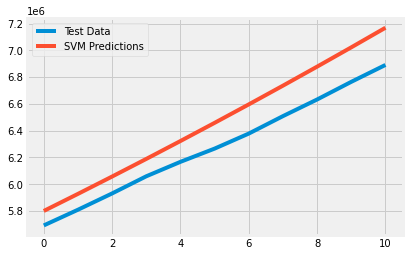

In [20]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

# bayesian ridge polynomial regression

In [33]:
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.8s finished
c:\users\technophyle ahmed\opencv\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [34]:
bayesian_search.best_params_

{'tol': 0.01,
 'normalize': True,
 'lambda_2': 0.001,
 'lambda_1': 0.001,
 'alpha_2': 1e-07,
 'alpha_1': 1e-06}

# estimating  bayesian confirmed 

In [35]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 292537.3233357685
MSE: 114897605500.14369


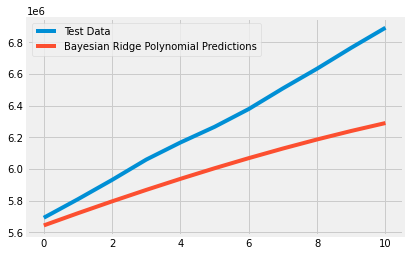

In [36]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

# transforming our data for polynomial regression

In [37]:
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=5)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

# polynomial regression

In [38]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 30279.386044414205
MSE: 1111482323.4684997


# getting the linear coefficient

In [31]:
print(linear_model.coef_)

[[ 2.87906993e+07 -1.59263994e+06  3.27135564e+04 -3.11685754e+02
   1.43762031e+00 -2.53847474e-03]]


# checking with the test data

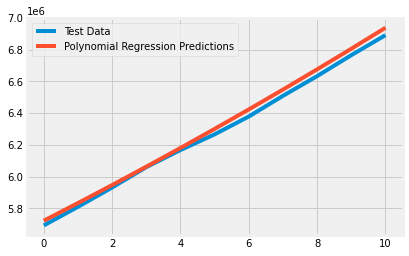

In [39]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

# Graphing the recorded confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

# world cases

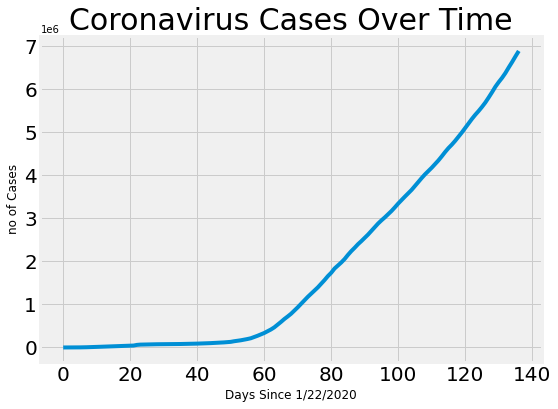

In [131]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, world_cases)
plt.title('Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# total deaths

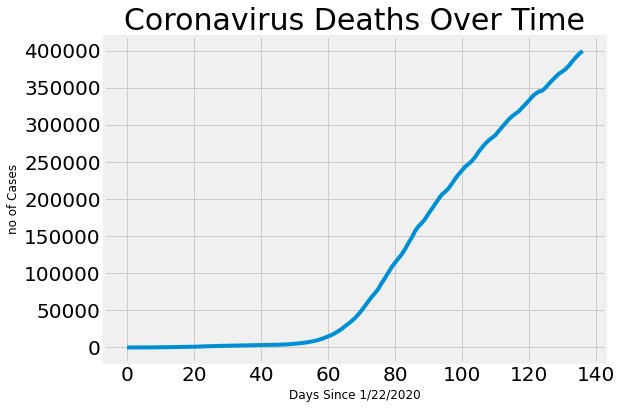

In [132]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, total_deaths)
plt.title('Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# recoveries

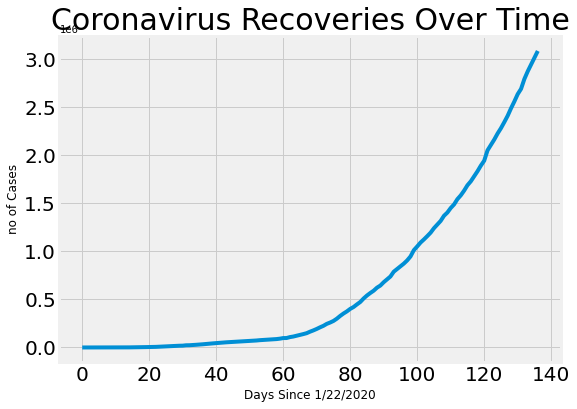

In [133]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, total_recovered)
plt.title('Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# active cases

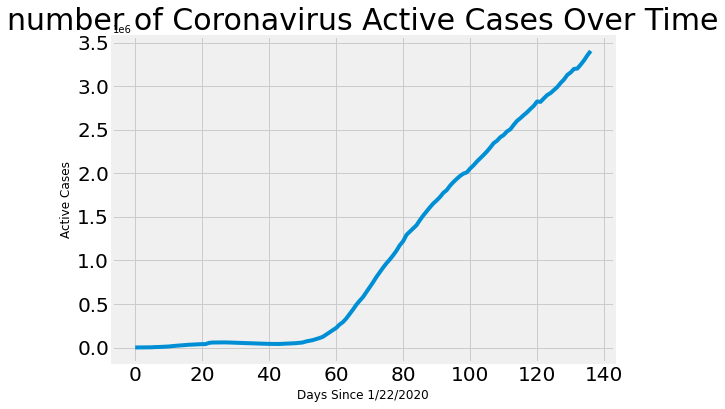

In [134]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, total_active)
plt.title('number of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('Active Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# graphing daily increase in confirmed cases, recoveries and deaths

# daily increase in confirmed cases 

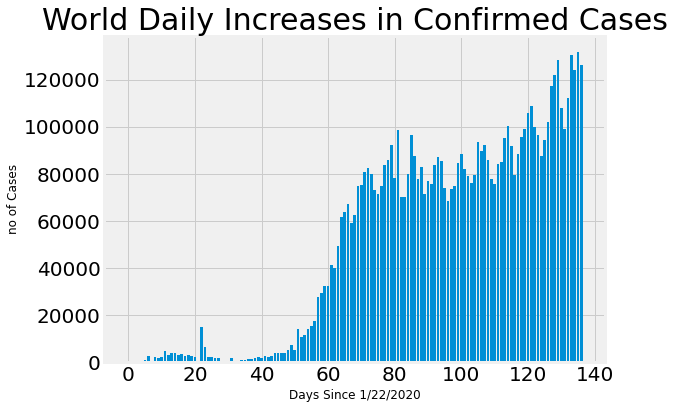

In [135]:
plt.figure(figsize=(8, 6))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# daily increase in deaths

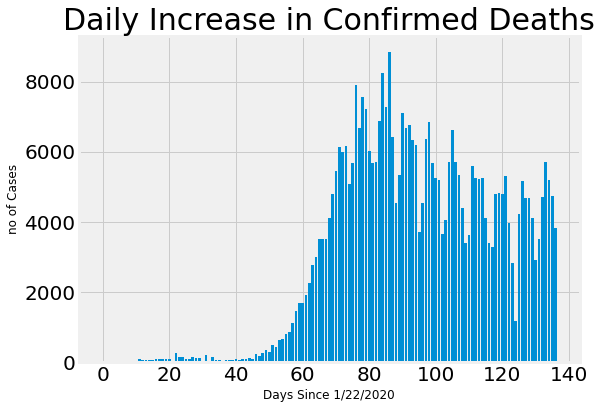

In [136]:
plt.figure(figsize=(8, 6))
plt.bar(adjusted_dates, world_daily_death)
plt.title('Daily Increase in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# daily increase in recoveries

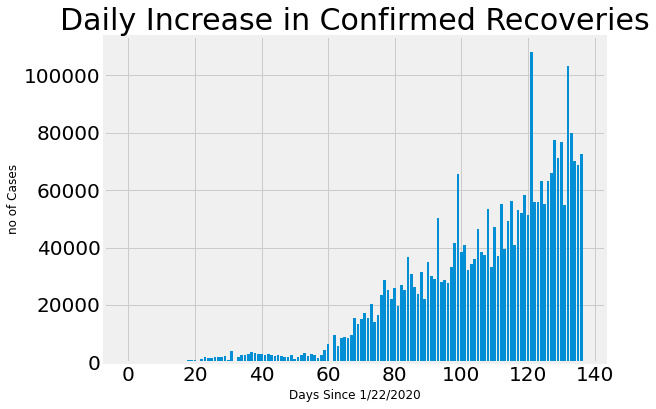

In [137]:
plt.figure(figsize=(8, 6))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('Daily Increase in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# function for plotting specific country's confirmed cases, daily increase in confirmed cases, deaths and recoveries

In [139]:
def country_plot(x, y1, y2, y3, y4, country):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y1)
    plt.title('{} Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020')
    plt.ylabel('no of Cases')
    plt.xticks()
    plt.yticks()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.bar(x, y2)
    plt.title('{} Daily Increases in Confirmed Cases'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020')
    plt.ylabel('no of Cases')
    plt.xticks()
    plt.yticks()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.bar(x, y3)
    plt.title('{} Daily Increases in Deaths'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020')
    plt.ylabel('no of Cases')
    plt.xticks()
    plt.yticks()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.bar(x, y4)
    plt.title('{} Daily Increases in Recoveries'.format(country), size=30)
    plt.xlabel('Days Since 1/22/2020')
    plt.ylabel('no of Cases')
    plt.xticks()
    plt.yticks()
    plt.show()

# China

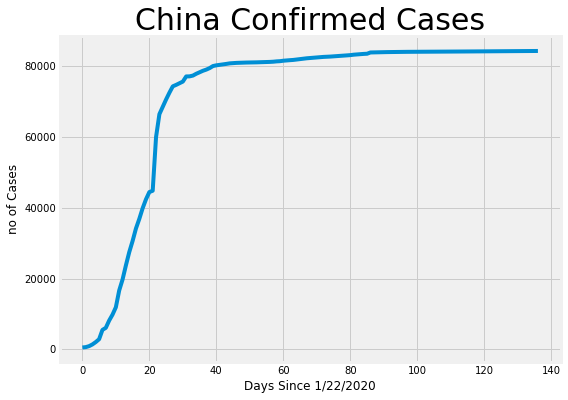

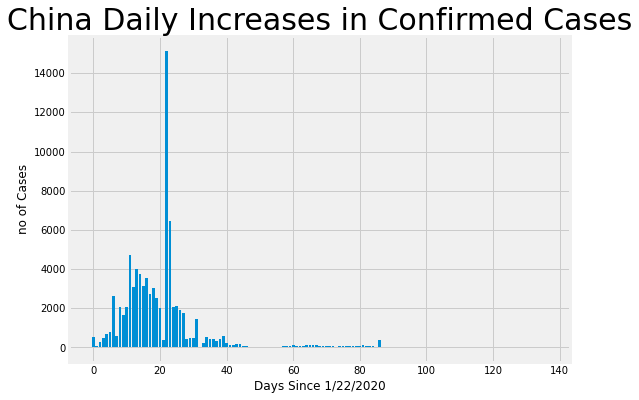

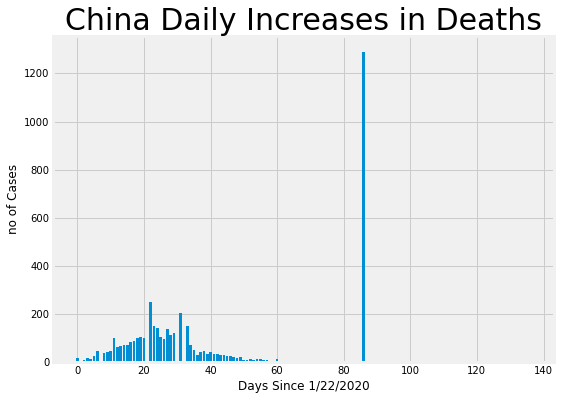

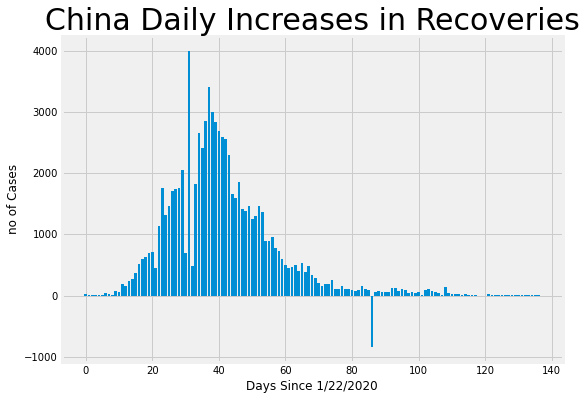

In [140]:
country_plot(adjusted_dates, china_cases, china_daily_increase, china_daily_death, china_daily_recovery, 'China')

# Unites States

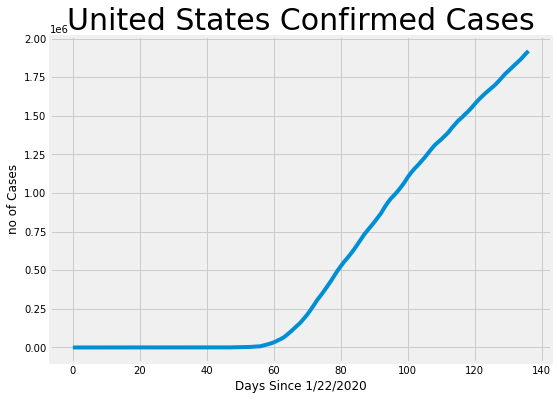

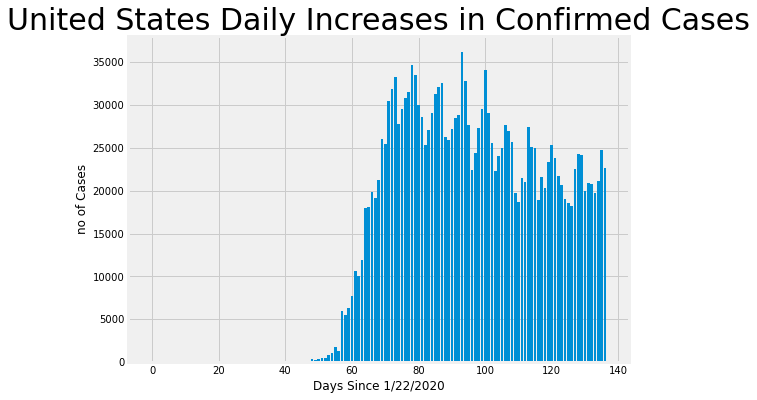

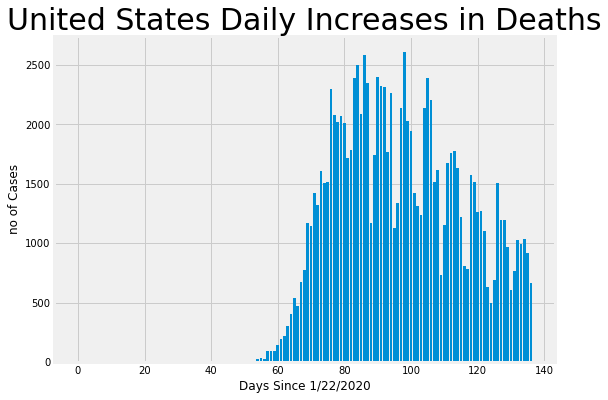

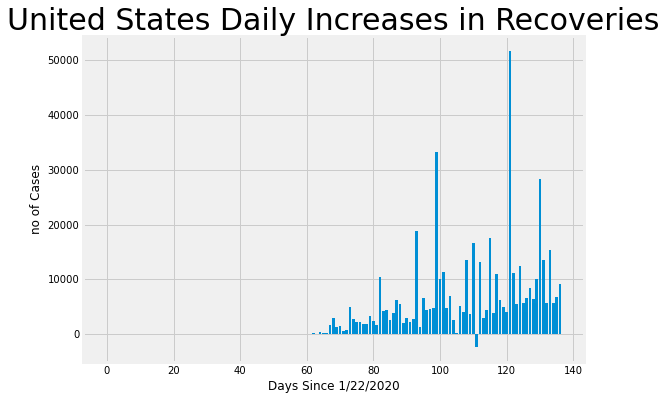

In [141]:
country_plot(adjusted_dates, us_cases, us_daily_increase, us_daily_death, us_daily_recovery, 'United States')

# comparing the number of cases in china, italy, us, spain, russia and india

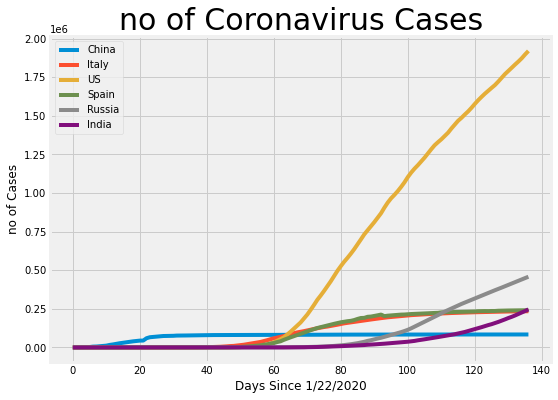

In [142]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, china_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, russia_cases)
plt.plot(adjusted_dates, india_cases)

plt.title('no of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.legend(['China', 'Italy', 'US', 'Spain', 'Russia', 'India'])
plt.xticks()
plt.yticks()
plt.show()

# comparing the number of deaths in china, italy, us, spain, russia and india

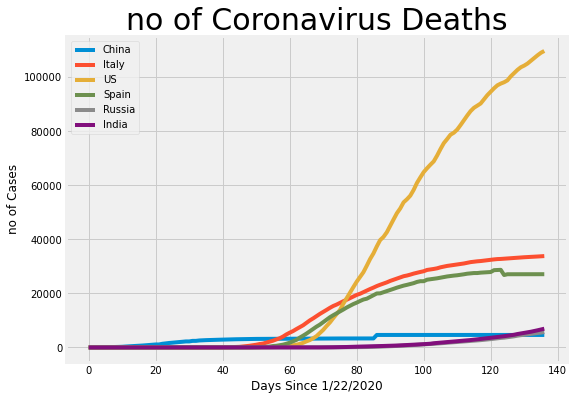

In [87]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, china_deaths)
plt.plot(adjusted_dates, italy_deaths)
plt.plot(adjusted_dates, us_deaths)
plt.plot(adjusted_dates, spain_deaths)
plt.plot(adjusted_dates, russia_deaths)
plt.plot(adjusted_dates, india_deaths)

plt.title('no of Coronavirus Deaths', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.legend(['China', 'Italy', 'US', 'Spain', 'Russia', 'India'])
plt.xticks()
plt.yticks()
plt.show()

# comparing the number of recoveries in china, italy, us, spain, russia and india

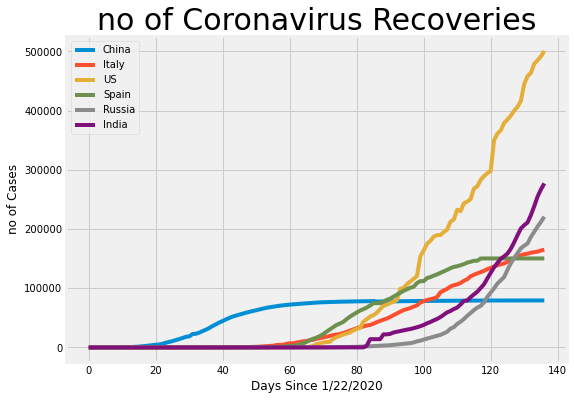

In [143]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, china_recoveries)
plt.plot(adjusted_dates, italy_recoveries)
plt.plot(adjusted_dates, us_recoveries)
plt.plot(adjusted_dates, spain_recoveries)
plt.plot(adjusted_dates, russia_recoveries)
plt.plot(adjusted_dates, brazil_recoveries)
plt.title('no of Coronavirus Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('no of Cases')
plt.legend(['China', 'Italy', 'US', 'Spain', 'Russia', 'India'])
plt.xticks()
plt.yticks()
plt.show()

# function for predicting the covid cases worldwide

In [92]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('no of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020')
    plt.ylabel('no of Cases')
    plt.legend(['Confirmed Cases', algo_name])
    plt.xticks()
    plt.yticks()
    plt.show()

# SVM prediction

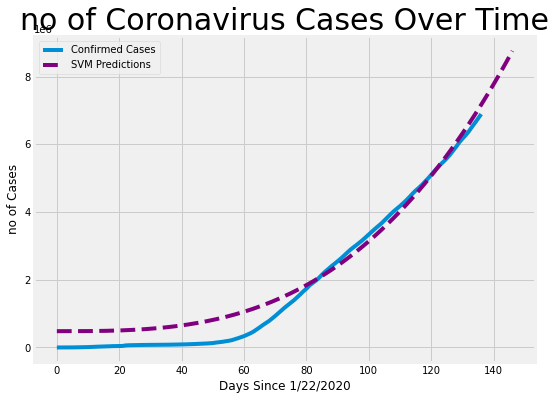

In [93]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

# bayesian ridge prediction

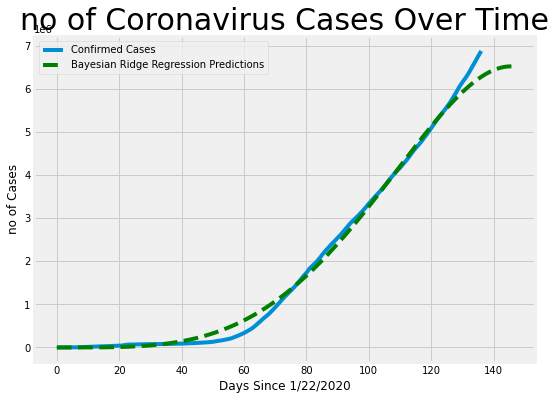

In [94]:
plot_predictions(adjusted_dates, world_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

# polynomial regression prediction

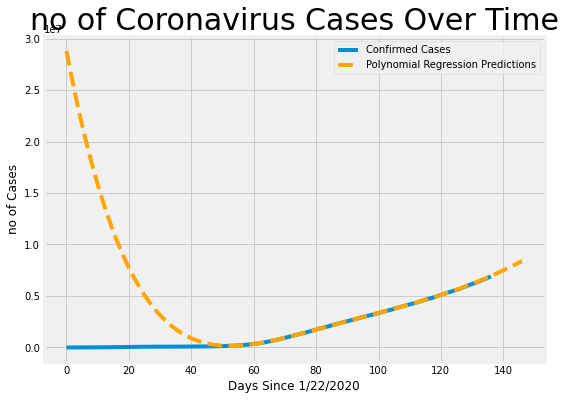

In [95]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

# future predictions using SVM

In [96]:
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,06/07/2020,7317788.0
1,06/08/2020,7468577.0
2,06/09/2020,7621567.0
3,06/10/2020,7776774.0
4,06/11/2020,7934214.0
5,06/12/2020,8093904.0
6,06/13/2020,8255858.0
7,06/14/2020,8420094.0
8,06/15/2020,8586626.0
9,06/16/2020,8755471.0


# future predictions using bayesian ridge

In [97]:
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Bayesian Ridge Predicted # of Confirmed Cases Worldwide': np.round(bayesian_pred[-10:])})
svm_df

,Date,Bayesian Ridge Predicted # of Confirmed Cases Worldwide
0,06/07/2020,6335570.0
1,06/08/2020,6377272.0
2,06/09/2020,6414559.0
3,06/10/2020,6447211.0
4,06/11/2020,6475003.0
5,06/12/2020,6497706.0
6,06/13/2020,6515086.0
7,06/14/2020,6526903.0
8,06/15/2020,6532913.0
9,06/16/2020,6532864.0


# future predictions using polynomial regression

In [98]:
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,06/07/2020,7072714.0
1,06/08/2020,7210038.0
2,06/09/2020,7349824.0
3,06/10/2020,7492058.0
4,06/11/2020,7636719.0
5,06/12/2020,7783778.0
6,06/13/2020,7933198.0
7,06/14/2020,8084932.0
8,06/15/2020,8238925.0
9,06/16/2020,8395112.0


# mortality rate of covid-19

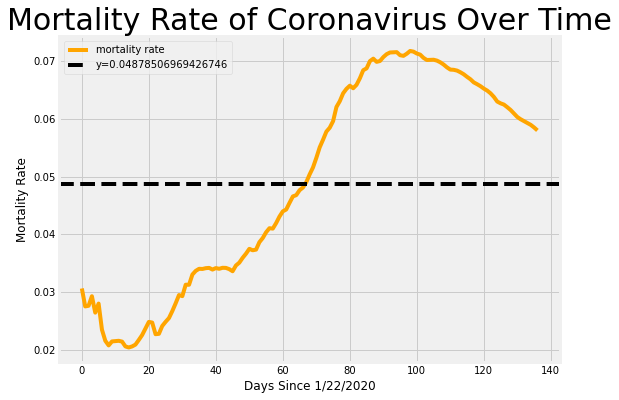

In [99]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)])
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('Mortality Rate')
plt.xticks()
plt.yticks()
plt.show()

# recovery rate

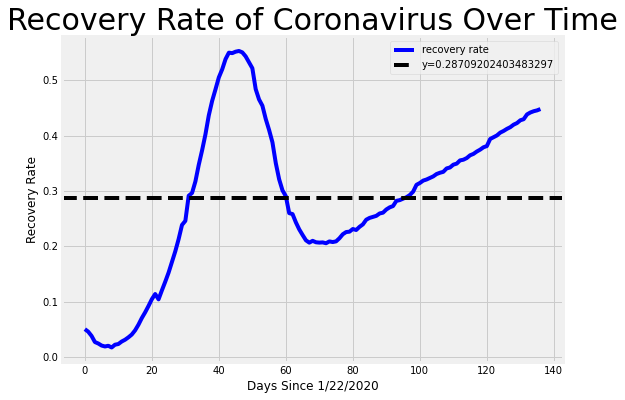

In [100]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)])
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('Recovery Rate')
plt.xticks()
plt.yticks()
plt.show()

# Death VS Recoveries (worldwide)

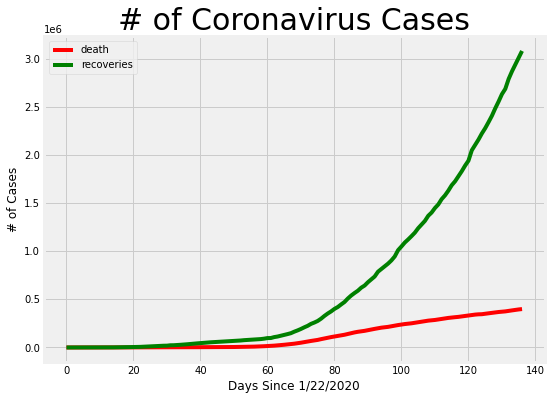

In [102]:
plt.figure(figsize=(8, 6))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best')
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020')
plt.ylabel('# of Cases')
plt.xticks()
plt.yticks()
plt.show()

# information about the countries having positive covid-19 cases

In [106]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [108]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

# Data Table

In [109]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})

# number of cases per country

In [110]:
country_df.style.background_gradient(cmap='Greens')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,1897380,109132,491706,1296542,0.057517
1,Brazil,645771,35026,0,610745,0.054239
2,Russia,449256,5520,212237,231499,0.012287
3,United Kingdom,284734,40344,1228,243162,0.141690
4,Spain,240978,27134,150376,63468,0.112599
5,India,236184,6649,113233,116302,0.028152
6,Italy,234531,33774,163781,36976,0.144007
7,France,190180,29114,70622,90444,0.153087
8,Peru,187400,5162,79214,103024,0.027545
9,Germany,184924,8658,168480,7786,0.046819


# information about the provinces/states with confirmed covid-19 cases

In [111]:
unique_provinces =  list(latest_data['Province_State'].unique())

In [114]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# removing areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

# Data Table

In [116]:
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})

# number of cases per province/state/city

In [117]:
province_df.style.background_gradient(cmap='Greens')

# handle nan if there is any, it is usually a float: float('nan')

In [118]:
nan_indices = [] 
for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

# Visualizations for covid-19

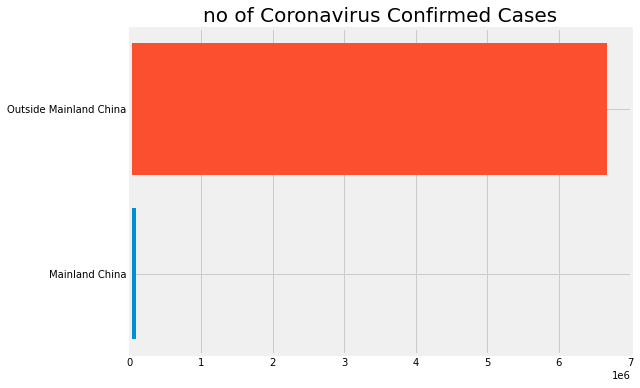

Outside Mainland China 6680741 cases:
Mainland China: 84177 cases
Total: 6764918 cases


In [119]:
china_confirmed = latest_data[latest_data['Country_Region']=='China']['Confirmed'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(8, 6))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('no of Coronavirus Confirmed Cases', size=20)
plt.xticks()
plt.yticks()
plt.show()
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

# Only show 15 countries with the most confirmed cases, the rest are grouped into the other category

In [121]:
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[15:])

for i in range(len(country_confirmed_cases[:15])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

# function for graphing the visualizations 

In [122]:
def plot_graphs(x, y, title):
    plt.figure(figsize=(8, 6))
    plt.barh(x, y)
    plt.title(title, size=20)
    plt.xticks()
    plt.yticks()
    plt.show()

# confirmed cases in countries

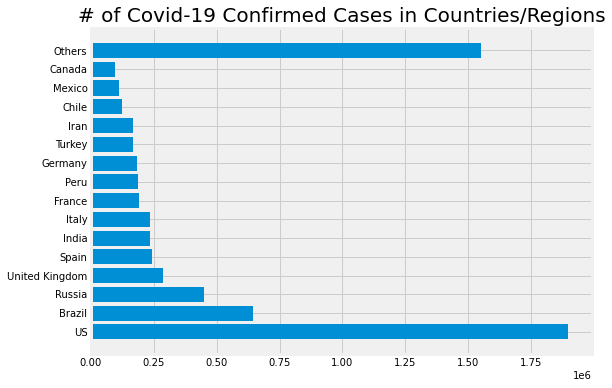

In [126]:
plot_graphs(visual_unique_countries, visual_confirmed_cases, '# of Covid-19 Confirmed Cases in Countries/Regions')

# Only show 15 provinces with the most confirmed cases, the rest are grouped into the other category

In [127]:
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[15:])
for i in range(len(province_confirmed_cases[:15])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

# confirmed cases in provinces/states

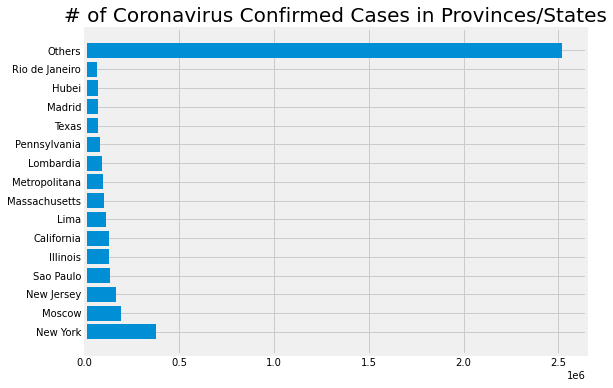

In [128]:
plot_graphs(visual_unique_provinces, visual_confirmed_cases2, '# of Coronavirus Confirmed Cases in Provinces/States')

# medical data of us for testing and hospitalisation

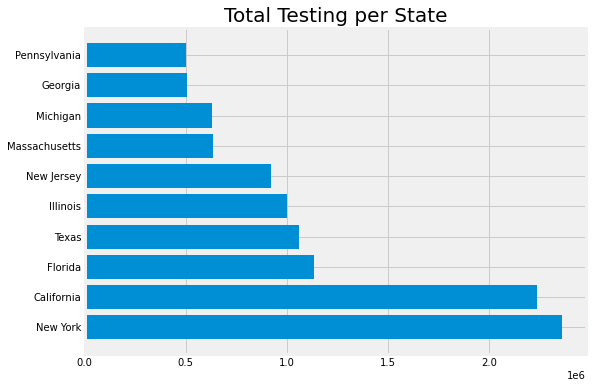

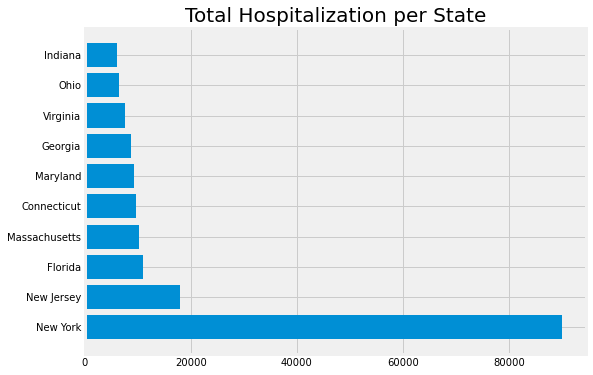

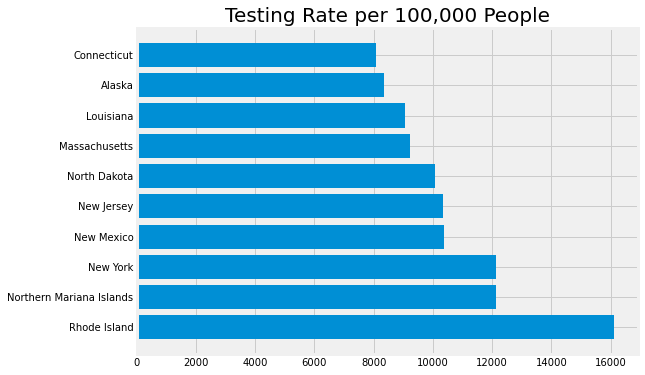

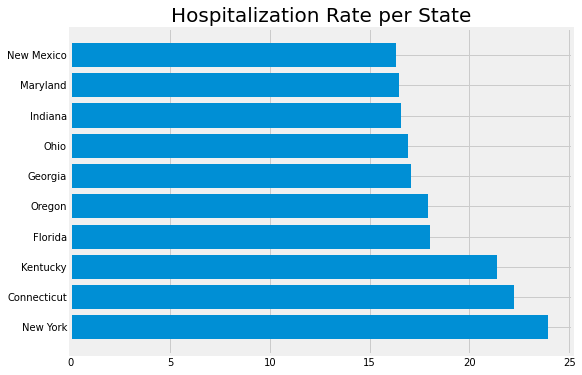

In [144]:
# Replace nan with 0
us_medical_data.fillna(value=0, inplace=True)

def plot_us_medical_data():
    states = us_medical_data['Province_State'].unique()
    testing_number = []
    hospitalization_number = [] 
    testing_rate = []
    hospitalization_rate = []
    
    for i in states:
        testing_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Tested'].sum())
        hospitalization_number.append(us_medical_data[us_medical_data['Province_State']==i]['People_Hospitalized'].sum())
        testing_rate.append(us_medical_data[us_medical_data['Province_State']==i]['Testing_Rate'].max())
        hospitalization_rate.append(us_medical_data[us_medical_data['Province_State']==i]['Hospitalization_Rate'].max())
    
    # only show the top 10 states
    testing_states = [k for k, v in sorted(zip(states, testing_number), key=operator.itemgetter(1), reverse=True)]
    hospitalization_states = [k for k, v in sorted(zip(states, hospitalization_number), key=operator.itemgetter(1), reverse=True)]
    testing_rate_states = [k for k, v in sorted(zip(states, testing_rate), key=operator.itemgetter(1), reverse=True)]
    hospitalization_rate_states = [k for k, v in sorted(zip(states, hospitalization_rate), key=operator.itemgetter(1), reverse=True)]
    
    for i in range(len(states)):
        testing_number[i] = us_medical_data[us_medical_data['Province_State']==testing_states[i]]['People_Tested'].sum()
        hospitalization_number[i] = us_medical_data[us_medical_data['Province_State']==hospitalization_states[i]]['People_Hospitalized'].sum()
        testing_rate[i] = us_medical_data[us_medical_data['Province_State']==testing_rate_states[i]]['Testing_Rate'].sum()
        hospitalization_rate[i] = us_medical_data[us_medical_data['Province_State']==hospitalization_rate_states[i]]['Hospitalization_Rate'].sum()
    
    plot_graphs(testing_states[:10], testing_number[:10], 'Total Testing per State')
    plot_graphs(hospitalization_states[:10], hospitalization_number[:10], 'Total Hospitalization per State')
    plot_graphs(testing_rate_states[:10], testing_rate[:10], 'Testing Rate per 100,000 People')
    plot_graphs(hospitalization_rate_states[:10], hospitalization_rate[:10], 'Hospitalization Rate per State')
    
plot_us_medical_data()